In [1]:
# Обработка входных данных

# Импорт библиотек
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, signal, fft, stats

In [2]:
path_input_acc = r"./input_acc.csv" # Путь до файла с данными акселерометра
path_input_gyro = r"./input_gyro.csv" # Путь до файла с данными гироскопа

# Создаём пустые массивы
tAcc_X = np.zeros(shape=256)
tAcc_Y = np.zeros(shape=256)
tAcc_Z = np.zeros(shape=256)
tGyro_X = np.zeros(shape=256)
tGyro_Y = np.zeros(shape=256)
tGyro_Z = np.zeros(shape=256)

# Массив для графиков (временная шкала)
t = np.arange(256)/100.0 # 256 - количество элементов в массиве, 100.0 - частота (Гц)

In [3]:
# Функция для получения массива с данными акселерометра из файла
def file_input(path, X, Y, Z, t):
    # path - путь до csv-файла с данными акселерометра
    # X, Y, Z - массивы с координатами по ося X, Y и Z соответственно
    # t - вспомогательная переменная, равна 'a' для акселерометра и 'g' для гироскопа
    fin = open(path, 'r')
    lines = fin.readlines() # Получаем список строк
    fin.close
    # Тут происходят фокусы унификации, чтобы одна функция работала
    # для двух методов ввода (в файлах разный формат ввода)
    if t=='a':
        n = 0
        f = 1
        char = '	'
    else:
        n = 1
        f = 2
        char = ','
    # Получаем из каждой строки элемент массива
    for i in range(1, 257*f, f):
        if t=='a': lines[i] = lines[i].replace(',', '.')
        lin = lines[i].split(char)
        if i < 256:
            X[i-1] = float(lin[n])
            Y[i-1] = float(lin[n+1])
            Z[i-1] = float(lin[n+2])

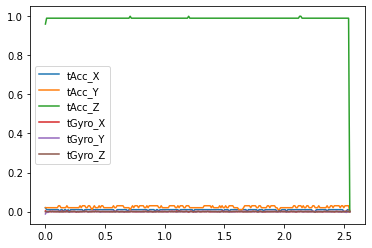

In [4]:
# Вызов функции
file_input(path_input_acc, tAcc_X, tAcc_Y, tAcc_Z, 'a')
file_input(path_input_gyro, tGyro_X, tGyro_Y, tGyro_Z, 'g')

# Вывод графика с массивами
plt.plot(t, tAcc_X, label='tAcc_X')
plt.plot(t, tAcc_Y, label='tAcc_Y')
plt.plot(t, tAcc_Z, label='tAcc_Z')
plt.plot(t, tGyro_X, label='tGyro_X')
plt.plot(t, tGyro_Y, label='tGyro_Y')
plt.plot(t, tGyro_Z, label='tGyro_Z')
plt.legend()
plt.show()
plt.close()

In [5]:
# Функция для медианного фильтра
def median_func(array, size=256):
    return ndimage.median_filter(array, size=size)

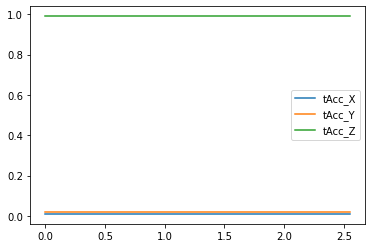

In [6]:
# Прогон каждого массива через фильтр
tAcc_X = median_func(tAcc_X)
tAcc_Y = median_func(tAcc_Y)
tAcc_Z = median_func(tAcc_Z)

# Вывод графика с массивами
plt.plot(t, tAcc_X, label='tAcc_X')
plt.plot(t, tAcc_Y, label='tAcc_Y')
plt.plot(t, tAcc_Z, label='tAcc_Z')
plt.legend()
plt.show()
plt.close()

In [7]:
# Функция эллипсоидного фильтра 
def ellip_filter(array, fs, fc, order=3, method='pad'):
    # fs - частота обработки, fc - частота среза (угловая частота)
    # w - скаляр критической частоты, order - порядок фильтра
    w = fc/(fs/2) # После перехода на другой тип фильтра не используется
    b, a = signal.ellip(fc/5, 0.01, fs, 0.125)
    output = signal.filtfilt(b, a, array, method=method)
    return output

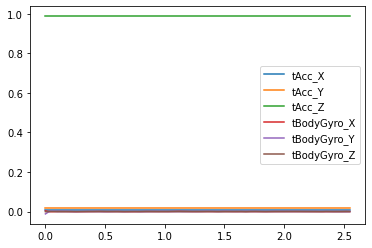

In [8]:
# Вызов функции (пропуск через фильтр массивов)
tAcc_X = ellip_filter(tAcc_X, 100, 20)
tAcc_Y = ellip_filter(tAcc_Y, 100, 20)
tAcc_Z = ellip_filter(tAcc_Z, 100, 20)
tBodyGyro_X = ellip_filter(tGyro_X, 100, 20)
tBodyGyro_Y = ellip_filter(tGyro_Y, 100, 20)
tBodyGyro_Z = ellip_filter(tGyro_Z, 100, 20)

# Вывод графика с массивами
plt.plot(t, tAcc_X, label='tAcc_X')
plt.plot(t, tAcc_Y, label='tAcc_Y')
plt.plot(t, tAcc_Z, label='tAcc_Z')
plt.plot(t, tBodyGyro_X, label='tBodyGyro_X')
plt.plot(t, tBodyGyro_Y, label='tBodyGyro_Y')
plt.plot(t, tBodyGyro_Z, label='tBodyGyro_Z')
plt.legend()
plt.show()
plt.close()

In [9]:
# Функция для выделения сигнала гравитации из сигнала акселерометра
def gravity_acc(array):
    w = 0.3/(35.9/2)
    b, a = signal.butter(1, w, 'low') # Фильтр Баттерворта 1 порядка
    g = signal.filtfilt(b, a, array, method='pad')
    g = median_func(g)
    g[0] = g[100]
    g[1] = g[101]
    return g/10.0

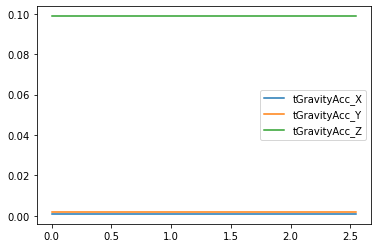

In [10]:
# Вызов функций для получения компоненты гравитации из сигнала
tGravityAcc_X = gravity_acc(tAcc_X)
tGravityAcc_Y = gravity_acc(tAcc_Y)
tGravityAcc_Z = gravity_acc(tAcc_Z)

# Вывод графиков гравитационных компонент по осям
plt.plot(t, tGravityAcc_X, label='tGravityAcc_X')
plt.plot(t, tGravityAcc_Y, label='tGravityAcc_Y')
plt.plot(t, tGravityAcc_Z, label='tGravityAcc_Z')
plt.legend()
plt.show()
plt.close()


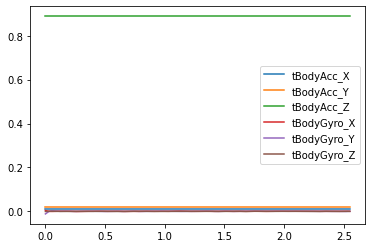

In [11]:
# Нахождение собственного ускорения тела
tBodyAcc_X = tAcc_X - tGravityAcc_X
tBodyAcc_Y = tAcc_Y - tGravityAcc_Y
tBodyAcc_Z = tAcc_Z - tGravityAcc_Z

# Вывод графика с ускорениями тела
plt.plot(t, tBodyAcc_X, label='tBodyAcc_X')
plt.plot(t, tBodyAcc_Y, label='tBodyAcc_Y')
plt.plot(t, tBodyAcc_Z, label='tBodyAcc_Z')
plt.plot(t, tBodyGyro_X, label='tBodyGyro_X')
plt.plot(t, tBodyGyro_Y, label='tBodyGyro_Y')
plt.plot(t, tBodyGyro_Z, label='tBodyGyro_Z')
plt.legend()
plt.show()
plt.close()

In [12]:
# Функция получения сигнала рывка из сигнала ускорения тела
def jerk_func(array):
    jerk_array = np.zeros(shape=256)
    for time in range(0, 256):
        if (time != 255): jerk_array[time]=(array[time+1]-array[time])*100
        else: jerk_array[time] = jerk_array[time-1]
    b, a = signal.ellip(4, 0.01, 120, 0.125) # Эллиптический фильтр
    jerk_array = signal.filtfilt(b, a, jerk_array, method="gust")
    return jerk_array

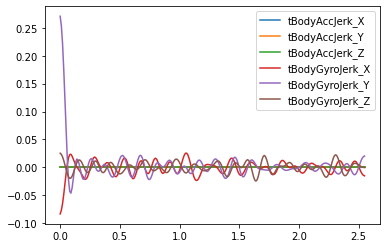

In [13]:
# Вызов функции для получения сигнала рывка
tBodyAccJerk_X = jerk_func(tBodyAcc_X)
tBodyAccJerk_Y = jerk_func(tBodyAcc_Y)
tBodyAccJerk_Z = jerk_func(tBodyAcc_Z)
tBodyGyroJerk_X = jerk_func(tBodyGyro_X)
tBodyGyroJerk_Y = jerk_func(tBodyGyro_Y)
tBodyGyroJerk_Z = jerk_func(tBodyGyro_Z)

# Вывод графика с рывками тела
plt.plot(t, tBodyAccJerk_X, label='tBodyAccJerk_X')
plt.plot(t, tBodyAccJerk_Y, label='tBodyAccJerk_Y')
plt.plot(t, tBodyAccJerk_Z, label='tBodyAccJerk_Z')
plt.plot(t, tBodyGyroJerk_X, label='tBodyGyroJerk_X')
plt.plot(t, tBodyGyroJerk_Y, label='tBodyGyroJerk_Y')
plt.plot(t, tBodyGyroJerk_Z, label='tBodyGyroJerk_Z')
plt.legend()
plt.show()
plt.close()

In [14]:
# Функция для получения скаляра магнитуды из вектора с тремя координатами
def magnitude_func(x, y, z): # x, y, z - массивы с координатами по осям X, Y, Z соответственно
    mag_array = np.zeros(shape=256)
    for i in range(0, 256):
        mag_array[i] = math.sqrt(x[i]*x[i] + y[i]*y[i] + z[i]*z[i])
    return mag_array

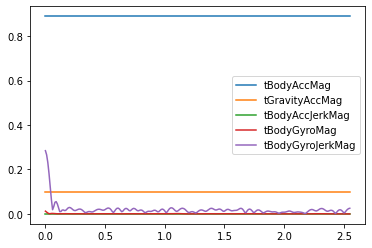

In [15]:
# Вызов функции для получения магнитуды
tBodyAccMag = magnitude_func(tBodyAcc_X, tBodyAcc_Y, tBodyAcc_Z)
tGravityAccMag = magnitude_func(tGravityAcc_X, tGravityAcc_Y, tGravityAcc_Z)
tBodyAccJerkMag = magnitude_func(tBodyAccJerk_X, tBodyAccJerk_Y, tBodyAccJerk_Z)
tBodyGyroMag = magnitude_func(tBodyGyro_X, tBodyGyro_Y, tBodyGyro_Z)
tBodyGyroJerkMag = magnitude_func(tBodyGyroJerk_X, tBodyGyroJerk_Y, tBodyGyroJerk_Z)

# Вывод графика с магнитудами
plt.plot(t, tBodyAccMag, label='tBodyAccMag')
plt.plot(t, tGravityAccMag, label='tGravityAccMag')
plt.plot(t, tBodyAccJerkMag, label='tBodyAccJerkMag')
plt.plot(t, tBodyGyroMag, label='tBodyGyroMag')
plt.plot(t, tBodyGyroJerkMag, label='tBodyGyroJerkMag')
plt.legend()
plt.show()
plt.close()

In [16]:
# Функция преобразования Фурье
def fft_func(array):
    fft_array = fft.fft(array, 256)
    return abs(fft_array)

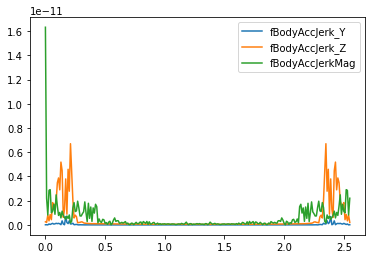

In [17]:
# Вызов функции для получения преобразований Фурье
fBodyAcc_X = fft_func(tBodyAcc_X)
fBodyAcc_Y = fft_func(tBodyAcc_Y)
fBodyAcc_Z = fft_func(tBodyAcc_Z)
fBodyAccJerk_X = fft_func(tBodyAccJerk_X)
fBodyAccJerk_Y = fft_func(tBodyAccJerk_Y)
fBodyAccJerk_Z = fft_func(tBodyAccJerk_Z)
fBodyAccJerkMag = fft_func(tBodyAccJerkMag)
fBodyAccMag = fft_func(tBodyAccMag)
fBodyGyro_X = fft_func(tBodyGyro_X)
fBodyGyro_Y = fft_func(tBodyGyro_Y)
fBodyGyro_Z = fft_func(tBodyGyro_Z)
fBodyGyroMag = fft_func(tBodyGyroMag)
fBodyGyroJerkMag = fft_func(tBodyGyroJerkMag)

# Вывод графиков с преобразованными массивами Фурье
#plt.plot(t, fBodyAcc_X, label='fBodyAcc_X')
#plt.plot(t, fBodyAcc_Y, label='fBodyAcc_Y')
#plt.plot(t, fBodyAcc_Z, label='fBodyAcc_Z')
#plt.plot(t, fBodyAccJerk_X, label='fBodyAccJerk_X')
plt.plot(t, fBodyAccJerk_Y, label='fBodyAccJerk_Y')
plt.plot(t, fBodyAccJerk_Z, label='fBodyAccJerk_Z')
plt.plot(t, fBodyAccJerkMag, label='fBodyAccJerkMag')
#plt.plot(t, fBodyAccMag, label='fBodyAccMag')
#plt.plot(t, fBodyGyro, label='fBodyGyro')
#plt.plot(t, fBodyGyroMag, label='fBodyGyroMag')
#plt.plot(t, fBodyGyroJerkMag, label='fBodyGyroJerkMag')
plt.legend()
plt.show()
plt.close()
# Некоторые графики закомментированы, потому что начальное значение некоторых
# массивов слишком большое, из-за чего не видны мелкие графики типа этого

In [18]:
# Удаление ненужных в дальнейшем массивов
del tAcc_X
del tAcc_Y
del tAcc_Z
del tGyro_X
del tGyro_Y
del tGyro_Z

In [19]:
# Функция для вычисления среднего значения массива
def mean_func(array):
    return np.mean(array)

# Функция для нахождения стандартного отклонения
def std_func(array):
    n = np.std(array, ddof=1)
    while abs(n) > 1:
        n = n/10.0
    return n

# Функция для нахождения медианного абсолютного отклонения
def mad_func(array):
    return stats.median_absolute_deviation(array)

# Функция для поиска максимума в массиве
def max_func(array):
    n = np.amax(array)
    while abs(n) > 1:
        n = n/10.0
    return n

# Функция для поиска минимума в массиве
def min_func(array):
    n = np.amin(array)
    while abs(n) > 1:
        n = n/10.0
    return n

# Функция для поиска области величины сигнала (SMA)
def sma_func(x, y, z):
    s = 0
    for i in range(0, 256):
        s = s + abs(x[i]) + abs(y[i]) + abs(z[i])
    return s/256.0

# Функция для нахождения меры энергии сигнала
def energy_func(array):
    s = 0
    n = array.size
    for i in range(0, n):
        s = s + (array[i]*array[i])
    en = s/n
    while abs(en) > 1:
        en = en/10.0
    return en

# Функция для поиска интерквартильныого размаха (IQR)
def iqr_func(array):
    n = stats.iqr(array)
    while abs(n) > 1:
        n = n/10.0
    return n

# Функция для поиска энтропии сигнала
def entropy_func(array):
    n = stats.entropy(array)
    if (abs(n) == math.inf): n = 0
    while n > 1:
        n = n/10.0
    return n

# Функция для нахождения коэффициентов авторегрессии 
def arCoeff_func(array, num):
    # array - входной массив, num - порядковый номер (от 1 до 4)
    array = abs(array)
    if np.amax(array) > 1: array = array/np.amax(array)
    b, a = signal.iirfilter(4, array, output='ba', fs = 100)
    a_max = np.amax(a)
    a_max_ind = np.argmax(a)
    a = a/(a_max*1000.0)
    b[0] = a[a_max_ind-1]
    b[1] = a[a_max_ind]
    b[2] = a[a_max_ind+1]
    b[3] = a[a_max_ind+2]
    n = b[num-1]
    while abs(n) > 1:
        n = n/10.0
    return n

# Функция для поиска коэффициента корреляции между двумя сигналами
def correlation_func(a1, a2):
    # a1, a2 - массивы сигналов
    n = signal.correlate(a1, a2)
    n2 = np.mean(n)
    while abs(n2) > 1:
        n2 = n2/10.0
    return n2

# Функция для нахождения наибольшей частотной составляющей
def maxInd_func(array):
    n = np.amax(array)
    while abs(n) > 1:
        n = n/10.0
    return n

# Функция для нахождения средневзвешенного значения частотных составляющих
def meanFreq_func(array):
    return abs(np.mean(array))

# Функция для поиска асимметрии частотной области сигнала
def skewness_func(array): 
    n = stats.skew(array)
    while abs(n) > 1:
        n = n/10.0
    return n

# Функция для поиска коэффициента эксцесса сигнала частотной области
def kurtosis_func(array):
    n = stats.kurtosis(array)
    while abs(n) > 1:
        n = n/10.0
    return n

# Функция для поиска энергии заданного частотного интервала 
def bandsEnergy_func(x, y, z, n1, n2):
    # x, y, z - массивы по осям соответственно
    # n1, n2 - диапазон частотного интервала (например, 1 и 8)
    l = (n2-n1)+1
    s = 0
    for i in range(n1-1, n2-1):
        s = s + (x[i]*x[i]+y[i]*y[i]+z[i]*z[i])
    n = s/(l*3)
    while abs(n) > 1:
        n = n/10.0
    return n

# Функция для нахождения угла между двумя векторами
def angle_func(x1, y1, z1, x2, y2, z2):
    # x1, y1, z1 - координаты первого вектора
    # x2, y2, z2 - координаты второго вектора
    m = (x1*x2)+(y1*y2)+(z1*z2)
    n1 = math.sqrt(x1*x1+y1*y1+z1*z1)
    n2 = math.sqrt(x2*x2+y2*y2+z2*z2)
    cos_alpha = m/(n1*n2)
    return cos_alpha

In [20]:
# Функция для темпоральных массивов по 3 осям
def t_general(x, y, z):
    # x, y, z - массивы по осям соответственно
    array = np.zeros(shape=40)
    array[0] = mean_func(x)
    array[1] = mean_func(y)
    array[2] = mean_func(z)
    array[3] = std_func(x)
    array[4] = std_func(y)
    array[5] = std_func(z)
    array[6] = mad_func(x)
    array[7] = mad_func(y)
    array[8] = mad_func(z)
    array[9] = max_func(x)
    array[10] = max_func(y)
    array[11] = max_func(z)
    array[12] = min_func(x)
    array[13] = min_func(y)
    array[14] = min_func(z)
    array[15] = sma_func(x, y, z)
    array[16] = energy_func(x)
    array[17] = energy_func(y)
    array[18] = energy_func(z)
    array[19] = iqr_func(x)
    array[20] = iqr_func(y)
    array[21] = iqr_func(z)
    array[22] = entropy_func(x)
    array[23] = entropy_func(y)
    array[24] = entropy_func(z)
    array[25] = arCoeff_func(x, 1)
    array[26] = arCoeff_func(x, 2)
    array[27] = arCoeff_func(x, 3)
    array[28] = arCoeff_func(x, 4)
    array[29] = arCoeff_func(y, 1)
    array[30] = arCoeff_func(y, 2)
    array[31] = arCoeff_func(y, 3)
    array[32] = arCoeff_func(y, 4)
    array[33] = arCoeff_func(z, 1)
    array[34] = arCoeff_func(z, 2)
    array[35] = arCoeff_func(z, 3)
    array[36] = arCoeff_func(z, 4)
    array[37] = correlation_func(x, y)
    array[38] = correlation_func(x, z)
    array[39] = correlation_func(y, z)
    return array

In [21]:
# Функция для темпоральных массивов магнитуд
def t_mag_general(mag):
    # mag - массив магнитуды
    array = np.zeros(shape=13)
    temp1 = np.zeros(shape=256)
    temp2 = np.zeros(shape=256)
    array[0] = mean_func(mag)
    array[1] = std_func(mag)
    array[2] = mad_func(mag)
    array[3] = max_func(mag)
    array[4] = min_func(mag)
    array[5] = sma_func(mag, temp1, temp2)
    array[6] = energy_func(mag)
    array[7] = iqr_func(mag)
    array[8] = entropy_func(mag)
    array[9] = arCoeff_func(mag, 1)
    array[10] = arCoeff_func(mag, 2)
    array[11] = arCoeff_func(mag, 3)
    array[12] = arCoeff_func(mag, 4)
    return array

In [22]:
# Получение первых 265 элементов вектора
# Темпоральные данные (зависят от времени)
t1 = t_general(tBodyAcc_X, tBodyAcc_Y, tBodyAcc_Z)
t2 = t_general(tGravityAcc_X, tGravityAcc_Y, tGravityAcc_Z)
t3 = t_general(tBodyAccJerk_X, tBodyAccJerk_Y, tBodyAccJerk_Z)
t4 = t_general(tBodyGyro_X, tBodyGyro_Y, tBodyGyro_Z)
t5 = t_general(tBodyGyroJerk_X, tBodyGyroJerk_Y, tBodyGyroJerk_X)
t6 = t_mag_general(tBodyAccMag)
t7 = t_mag_general(tGravityAccMag)
t8 = t_mag_general(tBodyAccJerkMag)
t9 = t_mag_general(tBodyGyroMag)
t10 = t_mag_general(tBodyGyroJerkMag)
t_global = np.concatenate((t1, t2, t3, t4, t5, t6, t7, t8, t9, t10))

In [23]:
# Функция для частотных массивов по 3 осям
def f_general(x, y, z):
    # x, y, z - массивы по осям соответственно
    array = np.zeros(shape=79)
    array[0] = mean_func(x)
    array[1] = mean_func(y)
    array[2] = mean_func(z)
    array[3] = std_func(x)
    array[4] = std_func(y)
    array[5] = std_func(z)
    array[6] = mad_func(x)
    array[7] = mad_func(y)
    array[8] = mad_func(z)
    array[9] = max_func(x)
    array[10] = max_func(y)
    array[11] = max_func(z)
    array[12] = min_func(x)
    array[13] = min_func(y)
    array[14] = min_func(z)
    array[15] = sma_func(x, y, z)
    array[16] = energy_func(x)
    array[17] = energy_func(y)
    array[18] = energy_func(z)
    array[19] = iqr_func(x)
    array[20] = iqr_func(y)
    array[21] = iqr_func(z)
    array[22] = entropy_func(x)
    array[23] = entropy_func(y)
    array[24] = entropy_func(z)
    array[25] = maxInd_func(x)
    array[26] = maxInd_func(y)
    array[27] = maxInd_func(z)
    array[28] = meanFreq_func(x)
    array[29] = meanFreq_func(y)
    array[30] = meanFreq_func(z)
    array[31] = skewness_func(x)
    array[32] = kurtosis_func(x)
    array[33] = skewness_func(y)
    array[34] = kurtosis_func(y)
    array[35] = skewness_func(z)
    array[36] = kurtosis_func(z)
    array[37] = bandsEnergy_func(x, y, z, 1, 8)
    array[38] = bandsEnergy_func(x, y, z, 9, 16)
    array[39] = bandsEnergy_func(x, y, z, 17, 24)
    array[40] = bandsEnergy_func(x, y, z, 25, 32)
    array[41] = bandsEnergy_func(x, y, z, 33, 40)
    array[42] = bandsEnergy_func(x, y, z, 41, 48)
    array[43] = bandsEnergy_func(x, y, z, 48, 56)
    array[44] = bandsEnergy_func(x, y, z, 57, 64)
    array[45] = bandsEnergy_func(x, y, z, 1, 16)
    array[46] = bandsEnergy_func(x, y, z, 17, 32)
    array[47] = bandsEnergy_func(x, y, z, 33, 48)
    array[48] = bandsEnergy_func(x, y, z, 49, 64)
    array[49] = bandsEnergy_func(x, y, z, 1, 24)
    array[50] = bandsEnergy_func(x, y, z, 25, 48)
    array[51] = bandsEnergy_func(x, y, z, 65, 72)
    array[52] = bandsEnergy_func(x, y, z, 73, 80)
    array[53] = bandsEnergy_func(x, y, z, 81, 88)
    array[54] = bandsEnergy_func(x, y, z, 89, 96)
    array[55] = bandsEnergy_func(x, y, z, 97, 104)
    array[56] = bandsEnergy_func(x, y, z, 105, 112)
    array[57] = bandsEnergy_func(x, y, z, 113, 120)
    array[58] = bandsEnergy_func(x, y, z, 121, 128)
    array[59] = bandsEnergy_func(x, y, z, 65, 80)
    array[60] = bandsEnergy_func(x, y, z, 81, 96)
    array[61] = bandsEnergy_func(x, y, z, 97, 112)
    array[62] = bandsEnergy_func(x, y, z, 113, 128)
    array[63] = bandsEnergy_func(x, y, z, 65, 88)
    array[64] = bandsEnergy_func(x, y, z, 89, 112)
    array[65] = bandsEnergy_func(x, y, z, 129, 136)
    array[66] = bandsEnergy_func(x, y, z, 137, 144)
    array[67] = bandsEnergy_func(x, y, z, 145, 152)
    array[68] = bandsEnergy_func(x, y, z, 153, 160)
    array[69] = bandsEnergy_func(x, y, z, 161, 168)
    array[70] = bandsEnergy_func(x, y, z, 169, 176)
    array[71] = bandsEnergy_func(x, y, z, 177, 184)
    array[72] = bandsEnergy_func(x, y, z, 185, 192)
    array[73] = bandsEnergy_func(x, y, z, 129, 144)
    array[74] = bandsEnergy_func(x, y, z, 145, 160)
    array[75] = bandsEnergy_func(x, y, z, 161, 176)
    array[76] = bandsEnergy_func(x, y, z, 177, 192)
    array[77] = bandsEnergy_func(x, y, z, 129, 152)
    array[78] = bandsEnergy_func(x, y, z, 153, 176)
    return array

In [24]:
# Функция для частотных массивов магнитуд
def f_mag_general(mag):
    # mag - массив магнитуды
    array = np.zeros(shape=13)
    temp1 = np.zeros(shape=256)
    temp2 = np.zeros(shape=256)
    array[0] = mean_func(mag)
    array[1] = std_func(mag)
    array[2] = mad_func(mag)
    array[3] = max_func(mag)
    array[4] = min_func(mag)
    array[5] = sma_func(mag, temp1, temp2)
    array[6] = energy_func(mag)
    array[7] = iqr_func(mag)
    array[8] = entropy_func(mag)
    array[9] = maxInd_func(mag)
    array[10] = meanFreq_func(mag)
    array[11] = skewness_func(mag)
    array[12] = kurtosis_func(mag)
    return array

In [25]:
# Частотные данные (после обработки FFT)
f1 = f_general(fBodyAcc_X, fBodyAcc_Y, fBodyAcc_Z)
f2 = f_general(fBodyAccJerk_X, fBodyAccJerk_Y, fBodyAccJerk_Z)
f3 = f_general(fBodyGyro_X, fBodyGyro_Y, fBodyGyro_Z)
f4 = f_mag_general(fBodyAccMag)
f5 = f_mag_general(fBodyAccJerkMag)
f6 = f_mag_general(fBodyGyroMag)
f7 = f_mag_general(fBodyGyroJerkMag)
f_global = np.concatenate((f1, f2, f3, f4, f5, f6, f7))

In [26]:
# Вычисление косинусов между углами
angle_arr = np.zeros(shape=7)
angle_arr[0] = angle_func(mean_func(tBodyAcc_X), mean_func(tBodyAcc_Y),
                          mean_func(tBodyAcc_Z), mean_func(tGravityAcc_X),
                          mean_func(tGravityAcc_Y), mean_func(tGravityAcc_Z))
angle_arr[1] = angle_func(mean_func(tBodyAccJerk_X), mean_func(tBodyAccJerk_Y),
                          mean_func(tBodyAccJerk_Z), mean_func(tGravityAcc_X),
                          mean_func(tGravityAcc_Y), mean_func(tGravityAcc_Z))
angle_arr[2] = angle_func(mean_func(tBodyGyro_X), mean_func(tBodyGyro_Y),
                          mean_func(tBodyGyro_Z), mean_func(tGravityAcc_X),
                          mean_func(tGravityAcc_Y), mean_func(tGravityAcc_Z))
angle_arr[3] = angle_func(mean_func(tBodyGyroJerk_X), mean_func(tBodyGyroJerk_Y),
                          mean_func(tBodyGyroJerk_Z), mean_func(tGravityAcc_X),
                          mean_func(tGravityAcc_Y), mean_func(tGravityAcc_Z))
angle_arr[4] = angle_func(1, 0, 0, mean_func(tGravityAcc_X), mean_func(tGravityAcc_Y), mean_func(tGravityAcc_Z))
angle_arr[5] = angle_func(0, 1, 0, mean_func(tGravityAcc_X), mean_func(tGravityAcc_Y), mean_func(tGravityAcc_Z))
angle_arr[6] = angle_func(0, 0, 1, mean_func(tGravityAcc_X), mean_func(tGravityAcc_Y), mean_func(tGravityAcc_Z))

In [27]:
# Получаем полный массив
global_array = np.concatenate((t_global, f_global, angle_arr))

In [28]:
# Удаление ненужных массивов
del tBodyAcc_X
del tBodyAcc_Y
del tBodyAcc_Z
del tGravityAcc_X
del tGravityAcc_Y
del tGravityAcc_Z
del tBodyAccJerk_X
del tBodyAccJerk_Y
del tBodyAccJerk_Z
del tBodyGyro_X
del tBodyGyro_Y
del tBodyGyro_Z
del tBodyGyroJerk_X
del tBodyGyroJerk_Y
del tBodyGyroJerk_Z
del tBodyAccMag
del tGravityAccMag
del tBodyAccJerkMag
del tBodyGyroMag
del tBodyGyroJerkMag
del fBodyAcc_X
del fBodyAcc_Y
del fBodyAcc_Z
del fBodyAccJerk_X
del fBodyAccJerk_Y
del fBodyAccJerk_Z
del fBodyGyro_X
del fBodyGyro_Y
del fBodyGyro_Z
del fBodyAccMag
del fBodyAccJerkMag
del fBodyGyroMag
del fBodyGyroJerkMag
del t1
del t2
del t3
del t4
del t5
del t6
del t7
del t8
del t9
del t10
del f1
del f2
del f3
del f4
del f5
del f6
del f7
del t_global
del f_global
del angle_arr

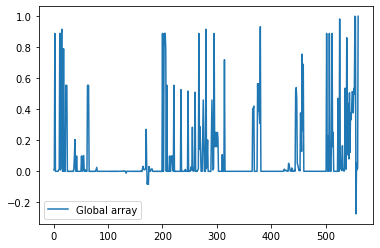

[ 8.97930057e-03  1.79586011e-02  8.88950757e-01  8.45941089e-17
  1.69188218e-16  2.85804694e-15  1.00304140e-16  2.00608280e-16
  2.46902498e-15  8.97930057e-03  1.79586011e-02  8.88950757e-01
  8.97930057e-03  1.79586011e-02  8.88950757e-01  9.15888659e-01
  8.06278388e-05  3.22511355e-04  7.90233448e-01  1.35308431e-16
  2.70616862e-16  3.33066907e-15  5.54517744e-01  5.54517744e-01
  5.54517744e-01 -8.00000018e-04  1.00000000e-03 -8.00000018e-04
  4.00000036e-04 -8.00000073e-04  1.00000000e-03 -8.00000073e-04
  4.00000146e-04 -8.00178191e-04  1.00000000e-03 -8.00178191e-04
  4.00356550e-04  2.06811195e-02  1.02371542e-01  2.04743084e-01
  9.97700064e-04  1.99540013e-03  9.87723063e-02  4.48315163e-19
  8.96630325e-19  1.39049725e-17  0.00000000e+00  0.00000000e+00
  0.00000000e+00  9.97700064e-04  1.99540013e-03  9.87723063e-02
  9.97700064e-04  1.99540013e-03  9.87723063e-02  1.01765407e-01
  9.95405417e-07  3.98162167e-06  9.75596850e-03  2.16840434e-19
  4.33680869e-19  0.00000

In [29]:
# Вывести график массива и сам массив
t = np.arange(561)
plt.plot(t, global_array, label='Global array')
plt.legend()
plt.show()
plt.close()
print(global_array)